In [42]:
import re
import ast
import torch
import numpy as np
from torch import nn
from multiprocessing import Pool, cpu_count
from Levenshtein import distance
from collections import Counter
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from torch.optim import AdamW 
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, accuracy_score

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [44]:
df = pd.read_csv(r"C:\Users\ASUS\PycharmProjects\2190513-Data-Science-Project\data.csv")
df["subject_areas"] = df["subject_areas"].apply(lambda x: ast.literal_eval(x))

In [38]:
display(df["subject_areas"].explode().value_counts())

subject_areas
Multidisciplinary             1088
Materials Science (all)        907
Chemistry (all)                905
Chemical Engineering (all)     755
Infectious Diseases            753
                              ... 
Museology                        1
Family Practice                  1
Emergency Nursing                1
Chiropractics                    1
Optometry                        1
Name: count, Length: 321, dtype: int64

In [45]:
df.dropna(subset=["abstract", "subject_areas"],inplace=True)


In [69]:
df

,eid,title,abstract,doi,publication_name,cover_date,citedby_count,author_ids,subject_areas,affiliations
0,2-s2.0-85066074915,Health and disease concepts: an approach to he...,Purpose: Health for all is an ideal goal that ...,10.1108/JHR-08-2018-045,Journal of Health Research,2018-11-07,1,['12041813500'],"[Health Policy, Public Health, Environmental a...",[]
1,2-s2.0-85048018727,Examining the relationships between HR practic...,Purpose: The purpose of this paper is to exten...,10.1108/APJBA-11-2017-0114,Asia-Pacific Journal of Business Administration,2018-11-06,23,['12140303400'],"[Business, Management and Accounting (all), Pu...",[]
2,2-s2.0-85061255485,Investigation of instructional design on readi...,This research aims to investigate the current ...,10.1145/3291078.3291100,ACM International Conference Proceeding Series,2018-11-05,3,"['57205711115', '56119381800', '6505939223']","[Software, Human-Computer Interaction, Compute...","[{'afid': None, 'name': 'Chulalongkorn Univers..."
3,2-s2.0-85054896135,Results of a real-world study on vortioxetine ...,Objective: The REVIDA study aimed to assess th...,10.1080/03007995.2018.1477746,Current Medical Research and Opinion,2018-11-02,12,"['57204192635', '7004330084', '56021778200', '...",[Medicine (all)],"[{'afid': None, 'name': 'Makati Medical Center..."
4,2-s2.0-85056159676,Optical Properties of Individual Aragonite Pla...,The unique structural architecture of nacre fr...,10.1002/slct.201801566,ChemistrySelect,2018-11-08,4,"['55237949400', '50462130300', '26538365800', ...",[Chemistry (all)],"[{'afid': None, 'name': 'Chulalongkorn Univers..."
...,...,...,...,...,...,...,...,...,...,...
20210,2-s2.0-85121585004,Comparison of the effect of hot and thermo-neu...,Exercise training is recommended to promote en...,10.48048/tis.2021.394,Trends in Sciences,2021-11-01,0,"['57382685800', '6508138646', '57193800471']",[Multidisciplinary],"[{'afid': None, 'name': 'Chulalongkorn Univers..."
20211,2-s2.0-85120995424,Measurement of prompt open-charm production cr...,The production cross sections for prompt open-...,10.1007/JHEP11(2021)225,Journal of High Energy Physics,2021-11-01,2,"['35222495600', '56217303000', '57195404626', ...",[Nuclear and High Energy Physics],"[{'afid': None, 'name': 'Rheinisch-Westfälisch..."
20212,2-s2.0-85120069769,Complete genome sequences of mycobacterium far...,Mycobacterium farcinogenes is a nonchromogenic...,10.1128/MRA.01005-21,Microbiology Resource Announcements,2021-11-01,0,"['24481984300', '35208717600', '12783320200', ...","[Molecular Biology, Immunology and Microbiolog...","[{'afid': None, 'name': 'Chulalongkorn Univers..."
20213,2-s2.0-85120059914,Adaptability of siamese rosewood and teak seed...,"Rosewood and Teak are valuable timber species,...",10.32526/ennrj/19/202100003,Environment and Natural Resources Journal,2021-11-01,2,"['54897960400', '57220119760', '25721817900']",[Environmental Science (all)],"[{'afid': None, 'name': 'Chulalongkorn Univers..."


In [5]:
label_mapping = {
    # Medicine & Health
    "Medicine (all)": "Medicine & Health",
    "Health Policy": "Medicine & Health",
    "Public Health, Environmental and Occupational Health": "Medicine & Health",
    "Neurology": "Medicine & Health",
    "Oncology": "Medicine & Health",
    "Radiology, Nuclear Medicine and Imaging": "Medicine & Health",
    "Pharmacology": "Medicine & Health",
    "Pediatrics, Perinatology and Child Health": "Medicine & Health",
    "Nursing (all)": "Medicine & Health",
    "Clinical Biochemistry": "Medicine & Health",
    "Cardiology and Cardiovascular Medicine": "Medicine & Health",

    # Biological Sciences
    "Biochemistry": "Biological Sciences",
    "Genetics": "Biological Sciences",
    "Microbiology": "Biological Sciences",
    "Plant Science": "Biological Sciences",
    "Animal Science and Zoology": "Biological Sciences",

    # Chemistry & Chemical Engineering
    "Chemistry (all)": "Chemistry & ChemEng",
    "Chemical Engineering (all)": "Chemistry & ChemEng",
    "Polymers and Plastics": "Chemistry & ChemEng",
    "Catalysis": "Chemistry & ChemEng",
    "Organic Chemistry": "Chemistry & ChemEng",

    # Physics & Astronomy
    "Nuclear and High Energy Physics": "Physics & Astronomy",
    "Physics and Astronomy (all)": "Physics & Astronomy",
    "Biophysics": "Physics & Astronomy",

    # Materials & Engineering
    "Engineering (all)": "Materials & Engineering",
    "Mechanical Engineering": "Materials & Engineering",
    "Civil and Structural Engineering": "Materials & Engineering",
    "Materials Science (all)": "Materials & Engineering",

    # Computer Science & AI
    "Artificial Intelligence": "CS & AI",
    "Software": "CS & AI",
    "Computer Science Applications": "CS & AI",
    "Computer Networks and Communications": "CS & AI",
    "Computer Vision and Pattern Recognition": "CS & AI",

    # Environmental & Earth Sciences
    "Environmental Science (all)": "Environment & Earth",
    "Ecology": "Environment & Earth",
    "Earth and Planetary Sciences (all)": "Environment & Earth",
    "Geology": "Environment & Earth",

    # Agriculture & Food
    "Food Science": "Agri & Food",
    "Agronomy and Crop Science": "Agri & Food",
    "Horticulture": "Agri & Food",

    # Business / Econ / Decision Sciences
    "Business, Management and Accounting (all)": "Business & Econ",
    "Finance": "Business & Econ",
    "Economics and Econometrics": "Business & Econ",
    "Management Science and Operations Research": "Business & Econ",

    # Social Sciences & Humanities
    "Education": "Social Sciences",
    "Psychology (all)": "Social Sciences",
    "Sociology and Political Science": "Social Sciences",

    # Multidisciplinary
    "Multidisciplinary": "Multidisciplinary",
}

def convert_labels(label_list):
    groups = []
    for lbl in label_list:
        if lbl in label_mapping:
            groups.append(label_mapping[lbl])
    if len(groups) == 0:
        return "Multidisciplinary"
    # Select the most frequent mapped group in this row
    return max(set(groups), key=groups.count)

df["area"] = df["subject_areas"].apply(convert_labels)
df = df[df['area'] != 'Multidisciplinary']
le = LabelEncoder()
df["label"] = le.fit_transform(df["area"])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26188\3888655706.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = le.fit_transform(df["area"])


In [46]:
def map_none_group(lst):
    if not isinstance(lst, list) or len(lst) == 0:
        return None
    
    # The mapping dictionary
    group_map = {
            "Science & Engineering": [
            "Computer Networks and Communications",
            "Electrical and Electronic Engineering",
            "Computer Science Applications",
            "Renewable Energy",
            "Sustainability and the Environment",
            "Organic Chemistry",
            "Energy Engineering and Power Technology",
            "Artificial Intelligence",
            "Analytical Chemistry",
            "Nuclear and High Energy Physics",
            "Physical and Theoretical Chemistry",
            "Materials Chemistry",
            "Condensed Matter Physics",
            "Computer Vision and Pattern Recognition",
            "Instrumentation",
            "Pollution",
            "Waste Management and Disposal",
            "Environmental Engineering",
            "Hardware and Architecture",
            "Electronic, Optical and Magnetic Materials",
            "Information Systems and Management",  # management-flavored IS often grouped with S&E in practice
            "Control and Optimization",
            "Environmental Chemistry",
            "Human-Computer Interaction",
            "Catalysis",
            "Building and Construction",
            "Mechanical Engineering",
            "Safety, Risk, Reliability and Quality",
            "Inorganic Chemistry",
            "Process Chemistry and Technology",
            "Physics and Astronomy (miscellaneous)",
            "Signal Processing",
            "Geotechnical Engineering and Engineering Geology",
            "Environmental Science (miscellaneous)",
            "Industrial and Manufacturing Engineering",
            "Surfaces, Coatings and Films",
            "Atomic and Molecular Physics",
            "Optics",
            "Metals and Alloys",
            "Mechanics of Materials",
            "Control and Systems Engineering",
            "Chemistry (miscellaneous)",
            "Chemical Engineering (miscellaneous)",
            "Water Science and Technology",
            "Computer Science (miscellaneous)",
            "Applied Mathematics",
            "Astronomy and Astrophysics",
            "Ceramics and Composites",
            "Space and Planetary Science",
            "Modeling and Simulation",
            "Electrochemistry",
            "Architecture",
            "Surfaces and Interfaces",
            "Nuclear Energy and Engineering",
            "Energy (miscellaneous)",
            "Transportation",
            "Colloid and Surface Chemistry",
            "Statistics and Probability",
            "Materials Science (miscellaneous)",
            "Automotive Engineering",
            "Filtration and Separation",
            "Computational Mathematics",
            "Atmospheric Science",
            "Computational Theory and Mathematics",
            "Computers in Earth Sciences",
            "Aerospace Engineering",
            "Numerical Analysis",
            "Mathematics (miscellaneous)",
            "Computational Mechanics",
            "Geophysics",
            "Algebra and Number Theory",
            "Theoretical Computer Science",
            "Acoustics and Ultrasonics",
            "Geometry and Topology",
            "Stratigraphy",
            "Human Factors and Ergonomics",
            "Statistical and Nonlinear Physics",
            "Paleontology",
            "Energy Engineering and Power Technology",  # duplicate concept sometimes listed twice
            "Fluid Flow and Transfer Processes",
            "Ocean Engineering",
            "Earth-Surface Processes",
            "Radiation",
            "Geochemistry and Petrology",
            "Economic Geology",
            "Space and Planetary Science",
            "Surface and Interfaces",
            "Ceramics and Composites",
            "Materials Science (miscellaneous)",
            "Structural Biology"  # included here for structural/biophysical methods overlap
        ],
        "Biomed & Life Sciences":[
            "Infectious Diseases",
            "Public Health",
            "Environmental and Occupational Health",
            "Biochemistry",
            "Molecular Biology",
            "Pharmaceutical Science",
            "Pharmacology",
            "Immunology",
            "Drug Discovery",
            "Ecology, Evolution, Behavior and Systematics",
            "Food Science",
            "Surgery",
            "Molecular Medicine",
            "Biotechnology",
            "Plant Science",
            "Neurology (clinical)",
            "Microbiology",
            "Oncology",
            "Pharmacology (medical)",
            "Animal Science and Zoology",
            "Immunology and Allergy",
            "Aquatic Science",
            "Genetics",
            "Gastroenterology",
            "Microbiology (medical)",
            "Radiology, Nuclear Medicine and Imaging",
            "Cancer Research",
            "Pediatrics, Perinatology and Child Health",
            "Bioengineering",
            "Neurology",
            "Orthopedics and Sports Medicine",
            "Biomedical Engineering",
            "Psychiatry and Mental Health",
            "Health, Toxicology and Mutagenesis",
            "Nephrology",
            "Hematology",
            "Cell Biology",
            "Cardiology and Cardiovascular Medicine",
            "Complementary and Alternative Medicine",
            "Virology",
            "Biomaterials",
            "Medicine (miscellaneous)",
            "Dermatology",
            "Nutrition and Dietetics",
            "Endocrinology, Diabetes and Metabolism",
            "Applied Microbiology and Biotechnology",
            "Ophthalmology",
            "Otorhinolaryngology",
            "Physiology",
            "Hepatology",
            "Clinical Biochemistry",
            "Ecology",
            "Parasitology",
            "Cellular and Molecular Neuroscience",
            "Epidemiology",
            "Obstetrics and Gynecology",
            "Biophysics",
            "Physical Therapy, Sports Therapy and Rehabilitation",
            "Pathology and Forensic Medicine",
            "Oral Surgery",
            "Critical Care and Intensive Care Medicine",
            "Pulmonary and Respiratory Medicine",
            "Physiology (medical)",
            "Health Informatics",
            "Agricultural and Biological Sciences (miscellaneous)",
            "Endocrinology",
            "Geriatrics and Gerontology",
            "Genetics (clinical)",
            "Urology",
            "Biological Psychiatry",
            "Toxicology",
            "Developmental Biology",
            "Transplantation",
            "Histology",
            "Internal Medicine",
            "Horticulture",
            "Rehabilitation",
            "Immunology and Microbiology (miscellaneous)",
            "Transplantation",
            "Food Animals",
            "Behavioral Neuroscience",
            "Clinical Psychology",
            "Radiological and Ultrasound Technology",
            "Cognitive Neuroscience",
            "Anatomy",
            "Biochemistry (medical)",
            "Pharmacology, Toxicology and Pharmaceutics (miscellaneous)",
            "Veterinary (miscellaneous)",
            "Forestry",
            "Anesthesiology and Pain Medicine",
            "Periodontics",
            "Pharmacy",
            "Rheumatology",
            "Dentistry (miscellaneous)",
            "Orthodontics",
            "Small Animals",
            "Medical and Surgical Nursing",
            "Oncology (nursing)",
            "Occupational Therapy",
            "Neuroscience (miscellaneous)",
            "Psychiatric Mental Health",
            "Speech and Hearing",
            "Dental Hygiene",
            "Podiatry",
            "Critical Care Nursing",
            "Care Planning",
            "Dental Assisting",
            "Chiropractics",
            "Emergency Nursing",
            "Family Practice",
            "Assessment and Diagnosis",
            "Optometry",
            "Emergency Medicine",
            "Equine",
            "Developmental Neuroscience",
            "Aging",
            "Advanced and Specialized Nursing",
            "Maternity and Midwifery",
            "Complementary and Manual Therapy",
            "Nursing (miscellaneous)",
            "Fundamentals and Skills",
            "Reproductive Medicine",
            "Medical Laboratory Technology",
            "Community and Home Care",
            "Geriatrics and Gerontology",
            "Small Animals"
        ],
        "Social & Humanities": [
            "Information Systems",
            "Management",
            "Monitoring, Policy and Law",
            "Geography, Planning and Development",
            "Health Policy",
            "Education",
            "Strategy and Management",
            "Information Systems and Management",
            "Management",
            "Management Science and Operations Research",
            "Management of Technology and Innovation",
            "Nature and Landscape Conservation",
            "Development",
            "History",
            "Finance",
            "Urban Studies",
            "Business and International Management",
            "Sociology and Political Science",
            "Social Sciences (miscellaneous)",
            "History and Philosophy of Science",
            "Political Science and International Relations",
            "Social Psychology",
            "Cultural Studies",
            "Marketing",
            "Language and Linguistics",
            "Linguistics and Language",
            "Organizational Behavior and Human Resource Management",
            "Business, Management and Accounting (miscellaneous)",
            "Management Information Systems",
            "Library and Information Sciences",
            "Visual Arts and Performing Arts",
            "Economics and Econometrics",
            "Economics, Econometrics and Finance (miscellaneous)",
            "Anthropology",
            "Statistics, Probability and Uncertainty",
            "Arts and Humanities (miscellaneous)",
            "Communication",
            "Accounting",
            "Decision Sciences (miscellaneous)",
            "Museology",
            "Law",
            "Tourism, Leisure and Hospitality Management",
            "Analysis",  # often an academic/humanities listing
            "Music",
            "Applied Psychology",
            "Literature and Literary Theory",
            "Public Administration",
            "Health (social science)",
            "Health Information Management",
            "Leadership and Management",
            "Logic",
            "Religious Studies",
            "Developmental and Educational Psychology",
            "Demography",
            "Archeology",
            "Archeology (arts and humanities)",
            "Library and Information Sciences",
            "Research and Theory",
            "Issues, Ethics and Legal Aspects",
            "Industrial Relations",
            "Life-span and Life-course Studies",
            "Fundamentals and Skills",
            "Gender Studies",
            "Media Technology",
            "Assessment and Diagnosis",
            "Organization Behavior and Human Resource Management"
        ]
    }
    
    groups = []
    for x in lst:
        assigned = None
        for group, items in group_map.items():
            if x in items:
                assigned = group
                break
        
        if assigned is None:  # Something doesn't belong to any group
            return None
        
        groups.append(assigned)
    
    # Check if all mapped groups are the same
    return groups[0] if len(set(groups)) == 1 else None

In [47]:
# Keep only rows where list length == 1
def extract_all_item(lst):
    if not isinstance(lst, list):
        return None
    matches = [item for item in lst if "(all)" in item]
    return matches[0] if len(matches) == 1 else None

def extract_more_all_item(lst):
    if not isinstance(lst, list):
        return None
    
    matches = [item for item in lst if "(all)" in item]
    
    return matches if len(matches) > 1 else None

# Apply extraction
df['area'] = df['subject_areas'].apply(extract_all_item)
df_multi = df[df['area'].isna()].copy()

# Keep only rows where 'area' is not NaN
df = df.dropna(subset=['area']).reset_index(drop=True)
df_multi = df_multi.reset_index(drop=True)

df_multi['multi_area'] = df_multi['subject_areas'].apply(extract_more_all_item)
df_unlabeled = df_multi[df_multi['multi_area'].isna()].copy()

df_multi = df_multi.dropna(subset=['multi_area']).reset_index(drop=True)
df_unlabeled = df_unlabeled.reset_index(drop=True)


def map_group(x):
    if x in ["Materials Science (all)", "Chemistry (all)", "Chemical Engineering (all)",
             "Physics and Astronomy (all)", "Engineering (all)", "Energy (all)",
             "Environmental Science (all)", "Mathematics (all)",
             "Computer Science (all)", "Earth and Planetary Sciences (all)",
             
             ]:
        return "Science & Engineering"
    
    if x in ["Medicine (all)", "Veterinary (all)", "Dentistry (all)", "Nursing (all)",
             "Biochemistry, Genetics and Molecular Biology (all)", "Neuroscience (all)",
             "Pharmacology, Toxicology and Pharmaceutics (all)",
             "Immunology and Microbiology (all)",
             "Agricultural and Biological Sciences (all)",
             "Health Professions (all)"]:
        return "Biomed & Life Sciences"
    
    return "Social & Humanities"

def map_multi_group(lst):
    if not isinstance(lst, list) or len(lst) == 0:
        return None
    
    # The mapping dictionary
    group_map = {
        "Science & Engineering": [
            "Materials Science (all)", "Chemistry (all)", "Chemical Engineering (all)",
            "Physics and Astronomy (all)", "Engineering (all)", "Energy (all)",
            "Environmental Science (all)", "Mathematics (all)",
            "Computer Science (all)", "Earth and Planetary Sciences (all)",
        ],
        "Biomed & Life Sciences": [
            "Medicine (all)", "Veterinary (all)", "Dentistry (all)", "Nursing (all)",
            "Biochemistry, Genetics and Molecular Biology (all)", "Neuroscience (all)",
            "Pharmacology, Toxicology and Pharmaceutics (all)",
            "Immunology and Microbiology (all)",
            "Agricultural and Biological Sciences (all)",
            "Health Professions (all)",
        ],
        "Social & Humanities": [
            "Social Sciences (all)", "Psychology (all)", "Business, Management and Accounting (all)",
            "Arts and Humanities (all)", "Economics, Econometrics and Finance (all)",
            "Decision Sciences (all)",
        ]
    }
    
    groups = []
    for x in lst:
        assigned = None
        for group, items in group_map.items():
            if x in items:
                assigned = group
                break
        
        if assigned is None:  # Something doesn't belong to any group
            return None
        
        groups.append(assigned)
    
    # Check if all mapped groups are the same
    return groups[0] if len(set(groups)) == 1 else None

df["group_label"] = df["area"].apply(map_group)

df_multi["group_label"] = df_multi["multi_area"].apply(map_multi_group)

df_unlabeled["group_label"] = df_unlabeled["subject_areas"].apply(map_none_group)

df.drop("area", axis=1)
df_multi.drop("multi_area", axis=1)
df_multi.drop("area", axis=1)
df_unlabeled.drop("multi_area", axis=1)
df_unlabeled.drop("area", axis=1)

df_multi = df_multi[df_multi["group_label"] == "Social & Humanities"].reset_index(drop=True)
df_unlabeled = df_unlabeled[df_unlabeled["group_label"] == "Social & Humanities"].reset_index(drop=True)

# Randomly sample 30% of those rows
rows_to_drop = df_unlabeled["group_label"].sample(frac=0.29, random_state=42).index

# Drop them
df_unlabeled = df_unlabeled.drop(rows_to_drop).reset_index(drop=True)


df = pd.concat([df, df_multi, df_unlabeled], ignore_index=True)

mask = df["group_label"] == "Science & Engineering"

# Randomly sample 30% of those rows
rows_to_drop = df[mask].sample(frac=0.5, random_state=42).index

# Drop them
df = df.drop(rows_to_drop).reset_index(drop=True)

mask = df["group_label"] == "Biomed & Life Sciences"

# Randomly sample 30% of those rows
rows_to_drop = df[mask].sample(frac=0.29, random_state=42).index

# Drop them
df = df.drop(rows_to_drop).reset_index(drop=True)

le = LabelEncoder()
df["label"] = le.fit_transform(df["group_label"])

df['group_label'].value_counts()


group_label
Biomed & Life Sciences    1250
Science & Engineering     1192
Social & Humanities        999
Name: count, dtype: int64

In [ ]:

df['group_label'].value_counts()

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    list(df["abstract"]), list(df["is_multidisciplinary"]), test_size=0.2, random_state=42
)

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X = tfidf.fit_transform(train_texts)

X_train, X_test, y_train, y_test = train_test_split(
    X, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

clf = LinearSVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Baseline Accuracy: 0.6095959595959596
              precision    recall  f1-score   support

           0       0.61      0.63      0.62      1008
           1       0.60      0.59      0.60       972

    accuracy                           0.61      1980
   macro avg       0.61      0.61      0.61      1980
weighted avg       0.61      0.61      0.61      1980


In [15]:
'''
df = pd.read_csv("./labeled.csv")

mask = (df['group_label'] == 'Social & Humanities') & (df['is_new'] == True)
to_drop = df[mask].sample(frac=0.3, random_state=42).index
df = df.drop(to_drop).reset_index(drop=True)
mask = (df['group_label'] == 'Science & Engineering') & (df['is_new'] == True)
to_drop = df[mask].index
df = df.drop(to_drop).reset_index(drop=True)
mask = (df['group_label'] == 'Biomed & Life Sciences') & (df['is_new'] == True)
to_drop = df[mask].index
df = df.drop(to_drop).reset_index(drop=True)
mask = (df['group_label'] == 'Science & Engineering') & (df['is_new'] == False)
to_drop = df[mask].sample(frac=0.25, random_state=42).index
df = df.drop(to_drop).reset_index(drop=True)
df["group_label"].value_counts()

le = LabelEncoder()
df['label'] = le.fit_transform(df['group_label'])
'''

In [48]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    list(df["abstract"]), 
    list(df["label"]),  # 👈 CHANGE THIS
    test_size=0.2, 
    random_state=42,
    stratify=list(df["label"])  # 👈 STRONGLY RECOMMENDED
)

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=384):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
model = AutoModelForSequenceClassification.from_pretrained(
    "allenai/scibert_scivocab_uncased",
    num_labels=3
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

scaler = GradScaler()

# Training
model.train()
for epoch in range(15):
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        with autocast():  # forward pass in fp16
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()  # scaled gradients for stability
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader)}")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels_batch = batch["labels"].numpy()
        all_labels.extend(labels_batch)

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

print("\nAccuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=list(le.classes_)))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\AppData\Local\Temp\ipykernel_43128\177436768.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_43128\177436768.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # forward pass in fp16


Epoch 1 Loss: 0.3612516813499983
Epoch 2 Loss: 0.1908551620882611
Epoch 3 Loss: 0.13123032381368238
Epoch 4 Loss: 0.07996312061021495
Epoch 5 Loss: 0.03917019692964332
Epoch 6 Loss: 0.01840560883283615
Epoch 7 Loss: 0.010664967083653738
Epoch 8 Loss: 0.019599364853875582
Epoch 9 Loss: 0.012962283090103504
Epoch 10 Loss: 0.009176356328088183
Epoch 11 Loss: 0.009131894771789396
Epoch 12 Loss: 0.01326619859698207
Epoch 13 Loss: 0.010403231046227522
Epoch 14 Loss: 0.0026019630563813585
Epoch 15 Loss: 0.0007641614349775536

Accuracy: 0.941944847605225
                        precision    recall  f1-score   support

Biomed & Life Sciences       0.95      0.98      0.97       250
 Science & Engineering       0.94      0.92      0.93       239
   Social & Humanities       0.92      0.92      0.92       200

              accuracy                           0.94       689
             macro avg       0.94      0.94      0.94       689
          weighted avg       0.94      0.94      0.94       6

In [52]:
df.head().to_csv("./sample.csv")

In [24]:
def clean_label_text(label):
    """Remove parenthetical junk like (all) or (miscellaneous)"""
    label = re.sub(r"\s*\(.*?\)\s*", "", label)
    return label.strip()

def get_parent_category(label):
    """Extract highest-level parent label using text rules"""
    label = clean_label_text(label)

    # Split using common hierarchical separators
    parts = re.split(r"\sand\s|,|/", label)

    # Use the first part as parent (dominant field)
    parent = parts[0].strip()

    return parent


# =========================================
# Apply Mapping
# =========================================
df["subject_areas"] = df["subject_areas"].apply(
    lambda lst: [get_parent_category(l) for l in lst]
)

# Remove duplicates within each label list
df["subject_areas"] = df["subject_areas"].apply(lambda lst: list(set(lst)))

# Drop rows that end up with no labels
df = df[df["subject_areas"].map(len) > 0].reset_index(drop=True)

In [5]:
def clean_labels(label_list):
    return [
        l for l in label_list
        if "(miscellaneous)" not in l and "(all)" not in l
    ]

df["subject_areas"] = df["subject_areas"].apply(clean_labels)

# ==============================
# Remove Low-Cardinality Labels
# ==============================
min_count = 500  # ⬅ Change threshold as needed

# Count occurrences of each label
label_counts = df["subject_areas"].explode().value_counts()

# Keep only labels appearing >= min_count times
valid_labels = set(label_counts[label_counts >= min_count].index)

def filter_rare_labels(label_list):
    return [l for l in label_list if l in valid_labels]

df["subject_areas"] = df["subject_areas"].apply(filter_rare_labels)

# Drop rows now having zero labels
df = df[df["subject_areas"].map(len) > 0].reset_index(drop=True)

print("Remaining label count:", len(valid_labels))

Remaining label count: 13


In [6]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["subject_areas"])
X_train, X_test, y_train, y_test = train_test_split(
    df["abstract"], Y, test_size=0.2, random_state=42
)

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class AbstractDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = list(texts)  # ensure list, not pandas Series
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=256,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = AbstractDataset(X_train, y_train)
test_dataset = AbstractDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [8]:
num_labels = y_train.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification"
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        logits = outputs.logits
        loss = criterion(logits, batch["labels"])
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss {total_loss:.4f}")


Epoch 1: Loss 54.6588
Epoch 2: Loss 40.5835
Epoch 3: Loss 35.8314


In [10]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].cpu().numpy()
        logits  = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device)
        ).logits
        
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)  # threshold

        y_true.extend(labels)
        y_pred.extend(preds)

print("F1 Micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 Macro:", f1_score(y_true, y_pred, average="macro"))


F1 Micro: 0.3475145544111061
F1 Macro: 0.27628828850529075



📄 Classification Report:
                                                      precision    recall  f1-score   support

                                        Biochemistry       0.00      0.00      0.00       128
                Computer Networks and Communications       0.67      0.36      0.47       133
                       Computer Science Applications       0.00      0.00      0.00       137
                            Condensed Matter Physics       0.00      0.00      0.00        97
               Electrical and Electronic Engineering       0.64      0.38      0.48       131
             Energy Engineering and Power Technology       0.61      0.28      0.38       119
                                 Infectious Diseases       0.66      0.86      0.75       139
                                 Materials Chemistry       0.57      0.27      0.37        99
                                   Molecular Biology       0.67      0.04      0.08        97
                                 

C:\Users\ASUS\Desktop\temp_env\2190513-Data-Science-Project\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\Desktop\temp_env\2190513-Data-Science-Project\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


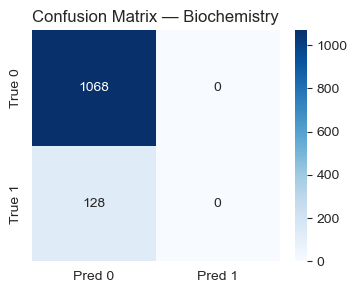

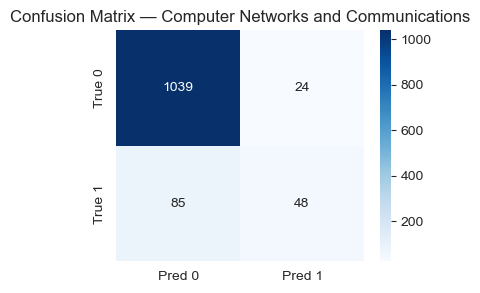

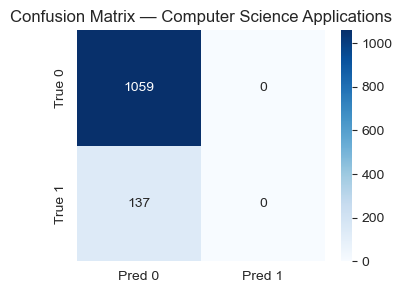

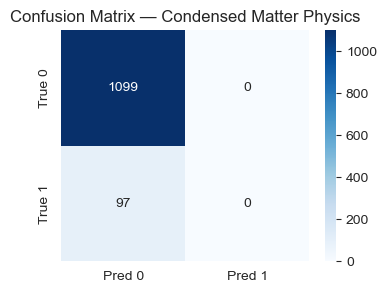

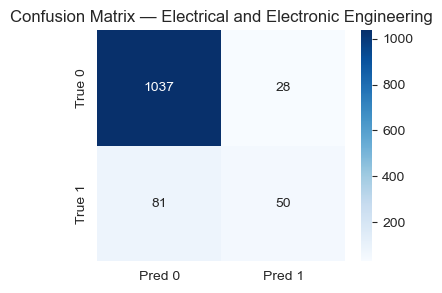

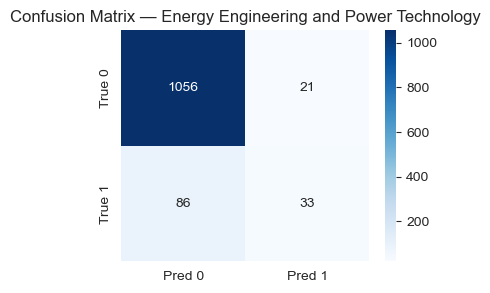

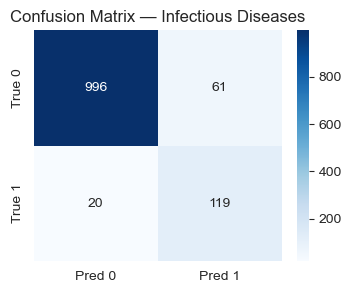

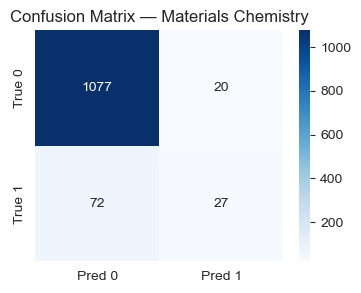

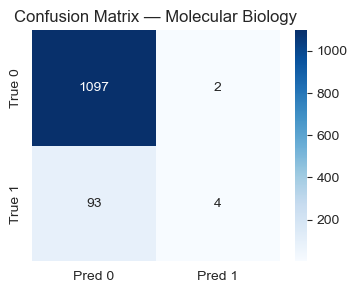

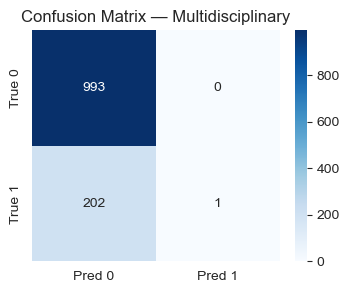

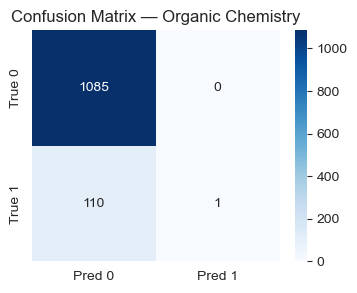

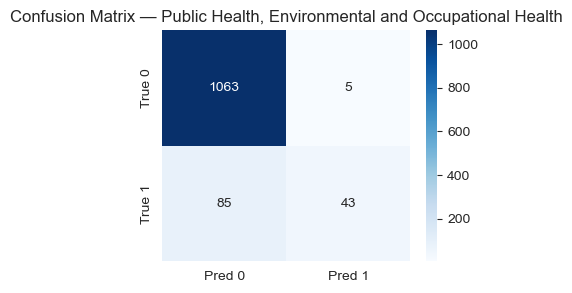

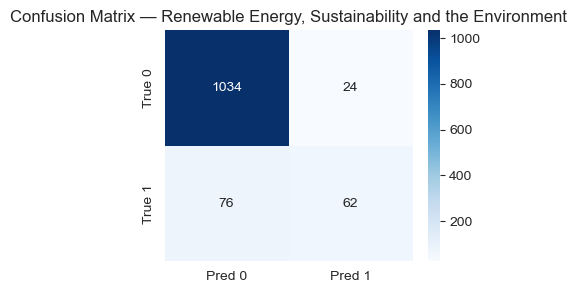

In [11]:
# Convert lists to numpy arrays if needed
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Confusion matrices — one per label
cms = multilabel_confusion_matrix(y_true, y_pred)

for i, label in enumerate(mlb.classes_):
    print(f"\n🔹 Confusion Matrix for label: {label}")
    print(cms[i])
    
for i, label in enumerate(mlb.classes_):
    plt.figure(figsize=(4,3))
    sns.heatmap(cms[i], annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0","Pred 1"],
                yticklabels=["True 0","True 1"])
    plt.title(f"Confusion Matrix — {label}")
    plt.show()

In [8]:
model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_df=0.8,
        min_df=5,
        ngram_range=(1,2),
        stop_words='english'
    )),
    ("svd", TruncatedSVD(n_components=300, random_state=42)),
    ("clf",  OneVsRestClassifier(MLPClassifier(
        hidden_layer_sizes=(512, 256),
        activation="relu",
        solver="adam",
        alpha=0.0005,
        learning_rate_init=0.001,
        max_iter=200,          # enough iterations
        tol=1e-1,              # relaxed threshold
        n_iter_no_change=200,   # more patience
        early_stopping=False,  # avoid premature stopping
        verbose=True
    )))
])


In [ ]:
model.fit(X_train, y_train)

Iteration 1, loss = 0.35284965
Iteration 2, loss = 0.28716842
Iteration 3, loss = 0.25936137
Iteration 4, loss = 0.23906434
Iteration 5, loss = 0.22246484
Iteration 6, loss = 0.20382842
Iteration 7, loss = 0.17735970
Iteration 8, loss = 0.14746344
Iteration 9, loss = 0.11507377
Iteration 10, loss = 0.08559277
Iteration 11, loss = 0.06396640
Iteration 12, loss = 0.05078416
Iteration 13, loss = 0.03511533
Iteration 14, loss = 0.02527911
Iteration 15, loss = 0.01962103
Iteration 16, loss = 0.01711646
Iteration 17, loss = 0.01493726
Iteration 18, loss = 0.01267311
Iteration 19, loss = 0.01095825
Iteration 20, loss = 0.00943651
Iteration 21, loss = 0.00801074
Iteration 22, loss = 0.00803777
Iteration 23, loss = 0.01448353
Iteration 24, loss = 0.01031531
Iteration 25, loss = 0.00904582
Iteration 26, loss = 0.00801749
Iteration 27, loss = 0.00679794
Iteration 28, loss = 0.00671727
Iteration 29, loss = 0.00606477
Iteration 30, loss = 0.00751012
Iteration 31, loss = 0.00548808
Iteration 32, los

C:\Users\ASUS\Desktop\temp_env\2190513-Data-Science-Project\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.32005397
Iteration 2, loss = 0.24083244
Iteration 3, loss = 0.20283217
Iteration 4, loss = 0.18177408
Iteration 5, loss = 0.16480985
Iteration 6, loss = 0.14535719
Iteration 7, loss = 0.12082270
Iteration 8, loss = 0.09590387
Iteration 9, loss = 0.07090815
Iteration 10, loss = 0.04908210
Iteration 11, loss = 0.03346597
Iteration 12, loss = 0.02251420
Iteration 13, loss = 0.01672549
Iteration 14, loss = 0.01285374
Iteration 15, loss = 0.00950921
Iteration 16, loss = 0.00750530
Iteration 17, loss = 0.00700519
Iteration 18, loss = 0.00754786
Iteration 19, loss = 0.00597877
Iteration 20, loss = 0.00701830
Iteration 21, loss = 0.00914764
Iteration 22, loss = 0.00557361
Iteration 23, loss = 0.00609998
Iteration 24, loss = 0.00440719
Iteration 25, loss = 0.00420701
Iteration 26, loss = 0.00417358
Iteration 27, loss = 0.00403782
Iteration 28, loss = 0.00400151
Iteration 29, loss = 0.00404004
Iteration 30, loss = 0.00382084
Iteration 31, loss = 0.00374298
Iteration 32, los

C:\Users\ASUS\Desktop\temp_env\2190513-Data-Science-Project\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.35378825
Iteration 2, loss = 0.27458972
Iteration 3, loss = 0.23538775
Iteration 4, loss = 0.21817335
Iteration 5, loss = 0.20165276
Iteration 6, loss = 0.18292847
Iteration 7, loss = 0.15817432
Iteration 8, loss = 0.13036907
Iteration 9, loss = 0.10226881
Iteration 10, loss = 0.07730710
Iteration 11, loss = 0.05497142
Iteration 12, loss = 0.04151654
Iteration 13, loss = 0.02816452
Iteration 14, loss = 0.01965927
Iteration 15, loss = 0.01728958
Iteration 16, loss = 0.01428404
Iteration 17, loss = 0.01096058
Iteration 18, loss = 0.01044663
Iteration 19, loss = 0.01124915
Iteration 20, loss = 0.00884088
Iteration 21, loss = 0.00833077
Iteration 22, loss = 0.00669713
Iteration 23, loss = 0.00881318
Iteration 24, loss = 0.00848767
Iteration 25, loss = 0.00904789
Iteration 26, loss = 0.00615294
Iteration 27, loss = 0.00710928
Iteration 28, loss = 0.01013777
Iteration 29, loss = 0.00789742
Iteration 30, loss = 0.01046928
Iteration 31, loss = 0.01869773
Iteration 32, los

C:\Users\ASUS\Desktop\temp_env\2190513-Data-Science-Project\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.28541108
Iteration 2, loss = 0.17179327
Iteration 3, loss = 0.13221958
Iteration 4, loss = 0.11797901
Iteration 5, loss = 0.10810327
Iteration 6, loss = 0.09873971
Iteration 7, loss = 0.08970128
Iteration 8, loss = 0.07745557
Iteration 9, loss = 0.06638899
Iteration 10, loss = 0.05526293
Iteration 11, loss = 0.04378162
Iteration 12, loss = 0.03473219
Iteration 13, loss = 0.02760973
Iteration 14, loss = 0.02238378
Iteration 15, loss = 0.01950710
Iteration 16, loss = 0.01668054
Iteration 17, loss = 0.01568778
Iteration 18, loss = 0.01309648
Iteration 19, loss = 0.00996131
Iteration 20, loss = 0.00990902
Iteration 21, loss = 0.00716794
Iteration 22, loss = 0.00719659
Iteration 23, loss = 0.00652933
Iteration 24, loss = 0.00792489
Iteration 25, loss = 0.00680031
Iteration 26, loss = 0.00643524
Iteration 27, loss = 0.00592825
Iteration 28, loss = 0.00557635
Iteration 29, loss = 0.00464671
Iteration 30, loss = 0.00431411
Iteration 31, loss = 0.00424738
Iteration 32, los

In [ ]:
df["subject_areas"].explode().value_counts()

In [36]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                               precision    recall  f1-score   support

                 Biochemistry       0.43      0.01      0.03       205
         Chemical Engineering       0.52      0.08      0.14       191
                    Chemistry       0.35      0.03      0.06       210
            Computer Networks       0.57      0.14      0.22       152
Computer Science Applications       0.40      0.03      0.06       129
     Condensed Matter Physics       1.00      0.03      0.05       107
                   Electrical       0.73      0.15      0.25       145
           Energy Engineering       0.44      0.03      0.06       122
                  Engineering       0.50      0.06      0.11       173
        Environmental Science       0.56      0.05      0.09        98
                   Immunology       0.64      0.18      0.28       131
          Infectious Diseases       0.65      0.38      0.48       145
          Materials Chemistry       0.00      0.00      0.00       113
     

C:\Users\ASUS\Desktop\temp_env\2190513-Data-Science-Project\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
